<a href="https://colab.research.google.com/github/GyaviWalls/extra_datasets/blob/main/Income_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Income Prediction.ipynb

> Author: Gyavira Ayebare.B.

## Imports

In [1]:
# general data package
import pandas as pd

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns

# visualisation import packages
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# base model formation packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# model instantiation packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# parameter adjust package
from sklearn.model_selection import GridSearchCV

# dimensional reduction package
from sklearn.decomposition import PCA


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Custom Evaluation Methods

In [3]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Second choice: Adult income dataset

In [4]:
filename = '/content/drive/MyDrive/CodingDojo/02-IntroML/Week07/Data/adult.csv'
df2 = pd.read_csv(filename)
df2.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df2.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


1. Source of data
> Obtained from the kaggle site [adult income dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)

2. Brief description of data
> The data contains an individual’s annual income results from various factors. These are influenced by the individual’s education level, age, gender, occupation, and etc.
 With this, the possibility in predicting income level based on the individual’s personal information can be achieved.

3. What is the target?
> The Income feature judged based on whether an individual earns less than or equal to 50K or greater than 50K

4. What does one row represent? (A person? A business? An event? A product?)
> The data of a person

5. Is this a classification or regression problem?
> Classification problem

6. How many features does the data have?
> 15 features

7. How many rows are in the dataset?
> 48842 rows

8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
>
* I might need to drop the education and occupation features, high cardinality issues
* Also converting the target feature to the appropriate class

## Project 2 - Part 2 (Core):

### Data cleaning

* Deleting unnecessary columns.

In [7]:
df2.nunique()

age                   74
workclass              9
fnlwgt             28523
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         123
capital-loss          99
hours-per-week        96
native-country        42
income                 2
dtype: int64

* Deleting duplicate rows.

In [8]:
print(df2.shape)
df2.drop_duplicates(inplace=True)
print(df2.shape)

(48842, 15)
(48790, 15)


* Identifying and addressing missing values.

In [9]:
df2.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

* Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).

In [10]:
cat_cols = df2.select_dtypes('object').columns
cat_cols

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'income'],
      dtype='object')

In [11]:
for cat in cat_cols:
  print(df2[cat].value_counts())
  print()


Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: education, dtype: int64

Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: marital-status, dtype: int64

Prof-specialty       6165
Craft-repair         6102
Exec-managerial      6082
Adm-clerical         

### Visualisations for both Numeric and Categorical features

* univariate visuals for the target and all features.




In [12]:
### Defining custom EDA visualisation functions

def plot_numeric(df,col):
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--',
            label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--',
            label=f"Median Value = ${med_value:,.2f}");


  sns.boxplot(data=df, x = col, ax = axes[1])
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()



def plot_bar(df, x):
    ## Make a larger fig/ax before plotting
    fig, ax = plt.subplots()

    counts = df[x].value_counts().sort_values(ascending=False).to_frame()
    ## ploting the barplot

    sns.barplot(data=counts,x=counts.index, y = counts[x],ax=ax)

    plt.xticks(rotation= 90)
    ax.set_title(f'Categorical Frequencies of {x}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(f'{x}', fontsize = 15, fontweight = 'bold')
    ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold')

    return fig,ax

#### Numeric feature visualisation plots

In [13]:
num_cols = df2.select_dtypes('number').columns
num_cols


Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

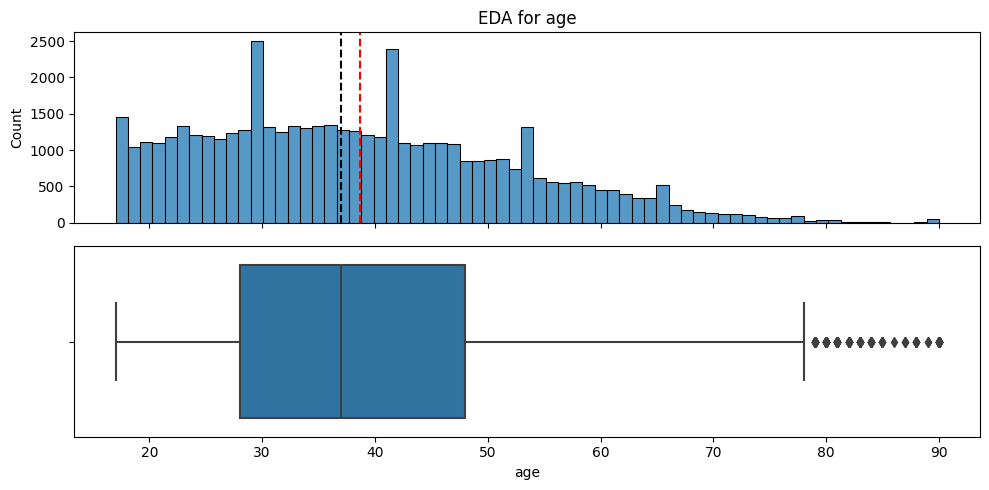

In [14]:
plot_numeric(df2, num_cols[0])

> In terms of age, there are a few outliers slightly beyond 75 and onward. I assume the age limit kicks in around there for this dataset.

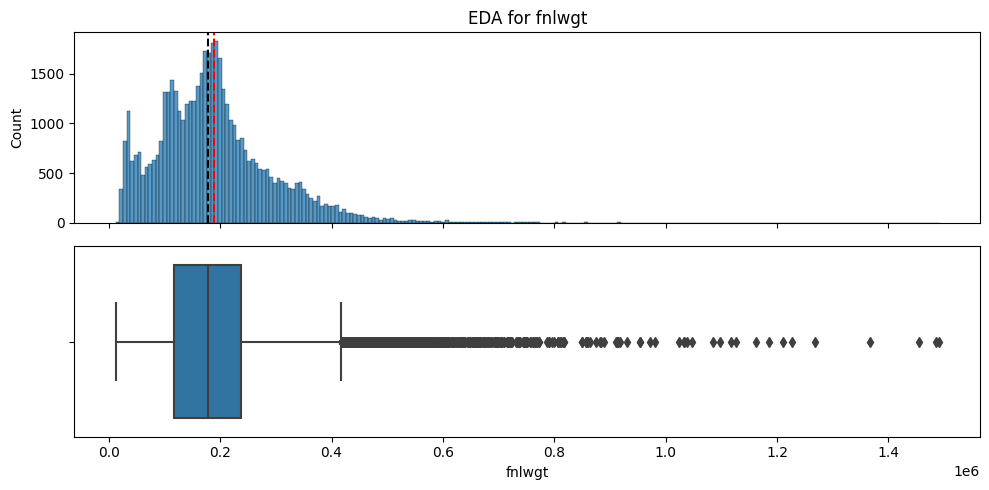

In [15]:
plot_numeric(df2, num_cols[1])

> The mean and median of the feature 'fnlwgt' are both below 0.2 as seen in the plot above

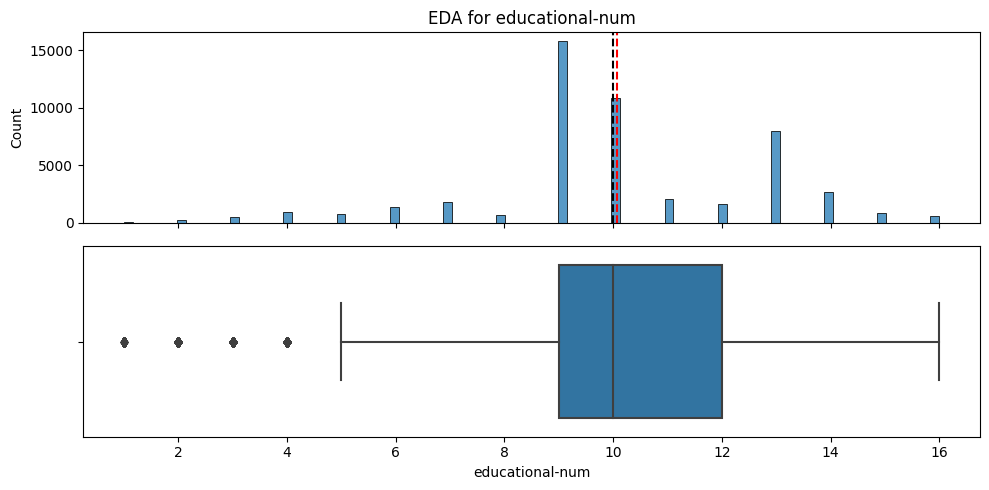

In [16]:
plot_numeric(df2, num_cols[2])

> Now this is unique, the feature 'educational-num' has outliers to the left of the quartile range all below 5 it seems.

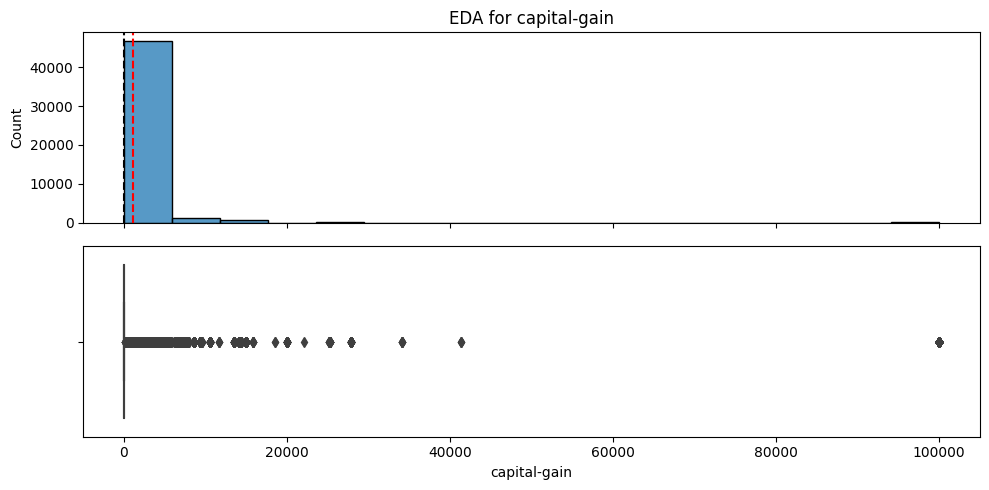

In [17]:
plot_numeric(df2, num_cols[3])

> There's a significant outlier at about 100000 that's way ahead from the previous outlier at 40000

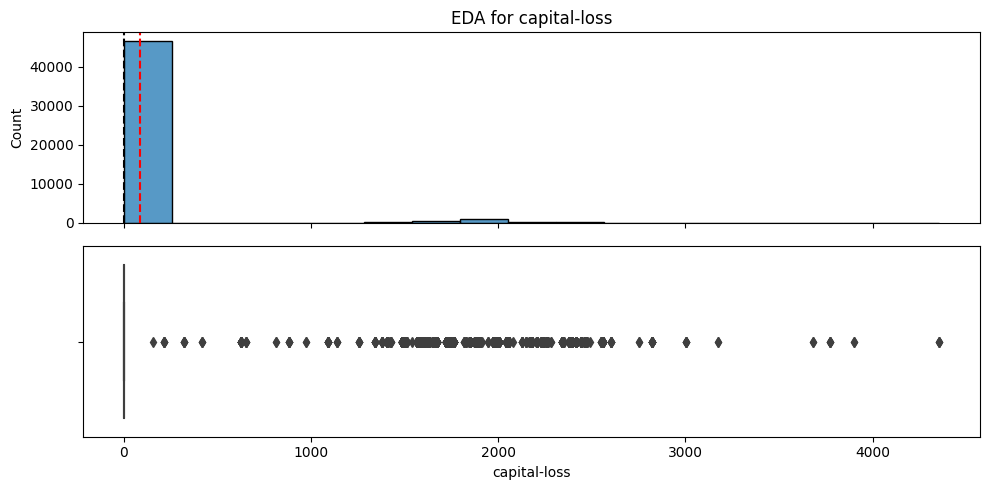

In [18]:
plot_numeric(df2, num_cols[4])

* Even though the mean value for capital-loss being above 0, it seems that also around 2000, there's some are significant capital-loss number in there.

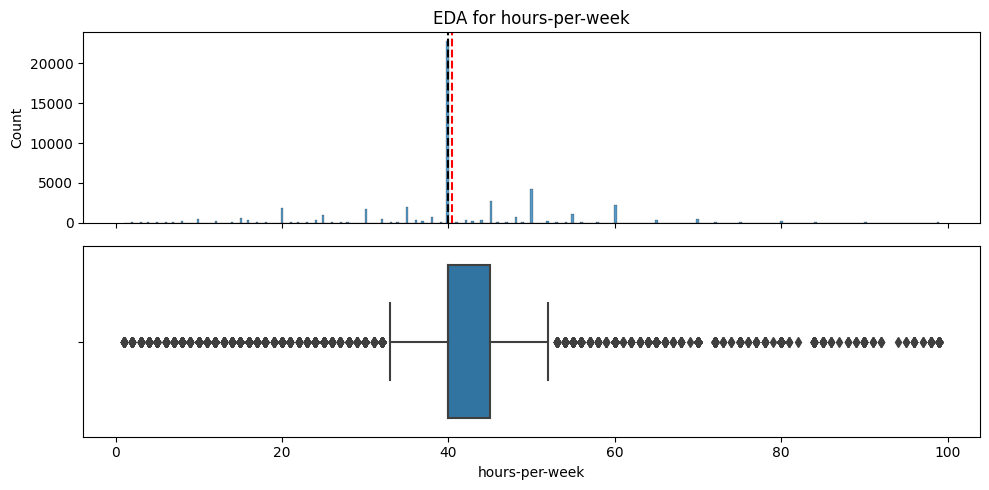

In [19]:
plot_numeric(df2, num_cols[5])

> * While time spent working is unrestricted, the dominant category appear to lie within the 20 - 60 hours worked per week.
* Wow, there are many outliers to either side of the quartile range.

#### Categorical feature visualisation plots

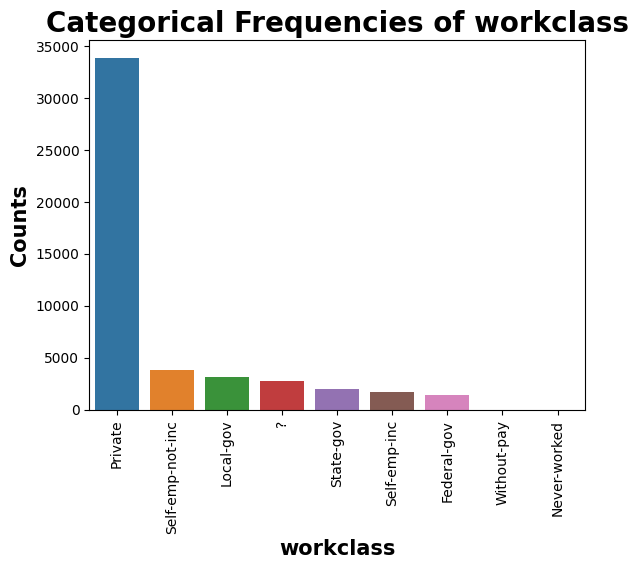

In [20]:
plot_bar(df2, cat_cols[0]);

> In terms of working class most of the individuals are in the 'privately' category whereas the least of them are in the 'Never-worked' category

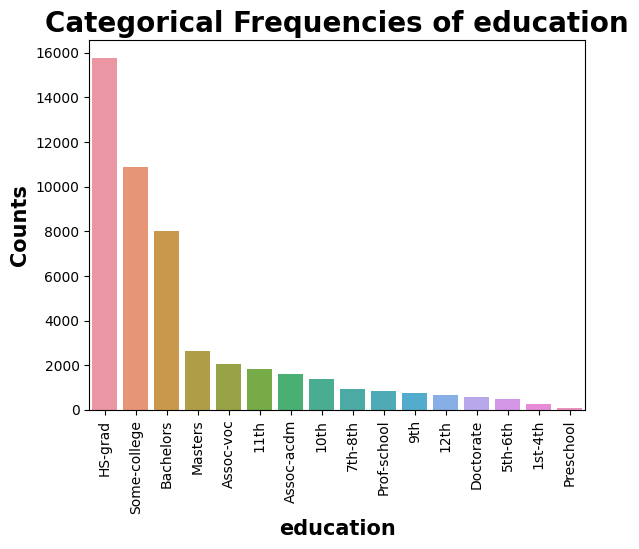

In [21]:
plot_bar(df2, cat_cols[1]);

> Most of the individuals finished till 'HS-grad' as the highest while 'Preschool' has the least number of individuals in terms of education level

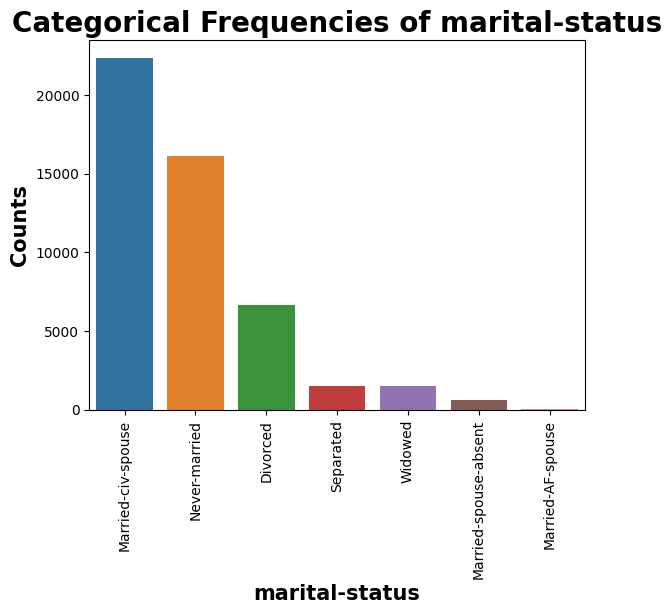

In [22]:
plot_bar(df2, cat_cols[2]);

> The categories with numbers above 5000 in the dataset are 'Married-civ-spouse', 'Never-married' and 'Divorced' the rest are below

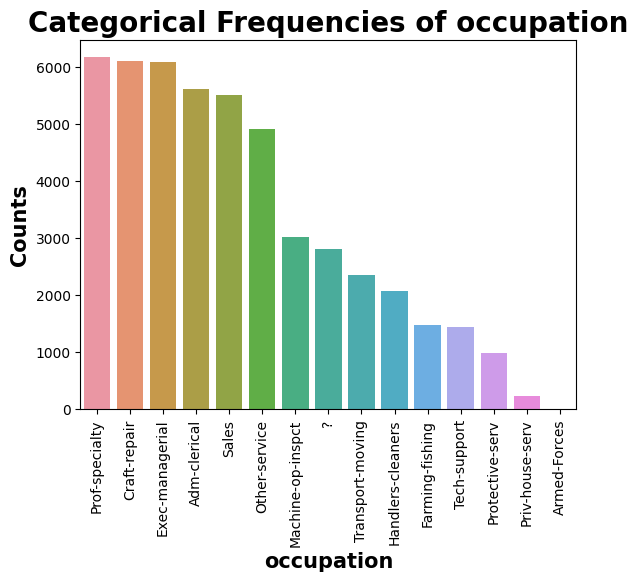

In [23]:
plot_bar(df2, cat_cols[3]);

> Prof-speciality has the highest number of individuals while Armed-forces has the least probably because of the risks involved in that occupation

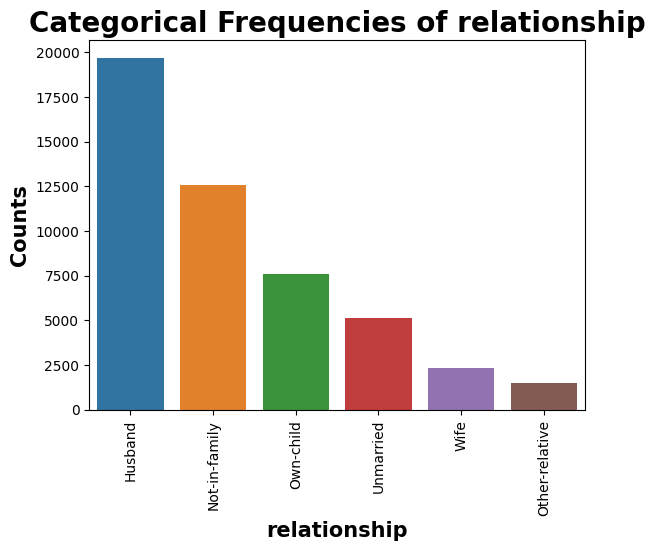

In [24]:
plot_bar(df2, cat_cols[4]);

> * It looks like the category that has the most individuals is 'Husband'
* While the lowest are some other relation apart from the existent ones in the data

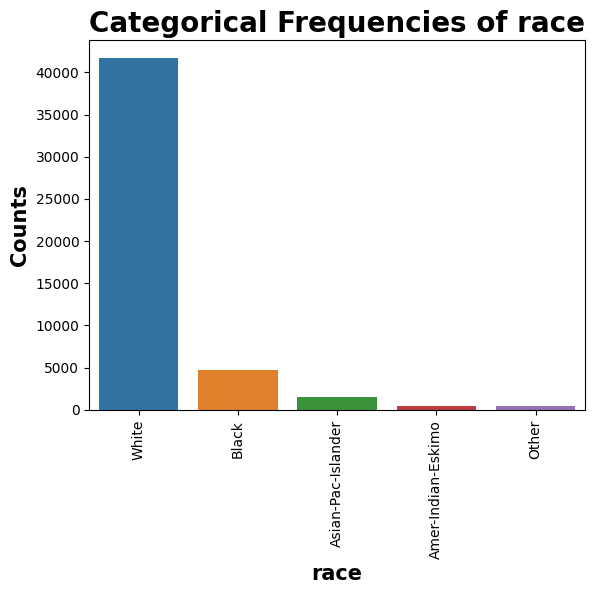

In [25]:
plot_bar(df2, cat_cols[5]);

> In terms of race, it seems like the number of white individuals is large. The dataset may be racist!

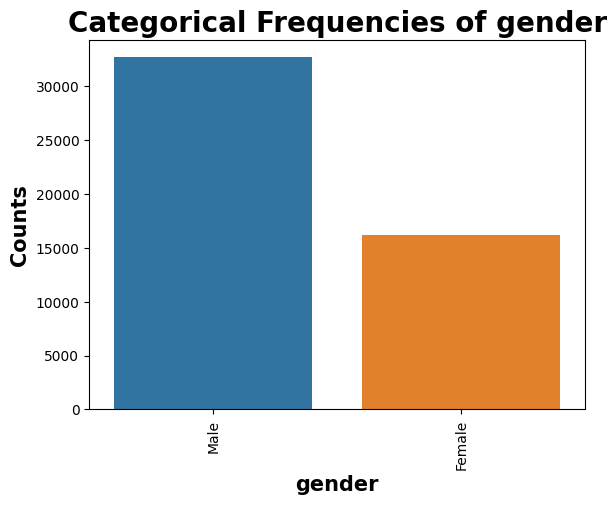

In [26]:
plot_bar(df2, cat_cols[6]);

> The number of individuals in male gender within the data is greater than that of female individuals by over 1000

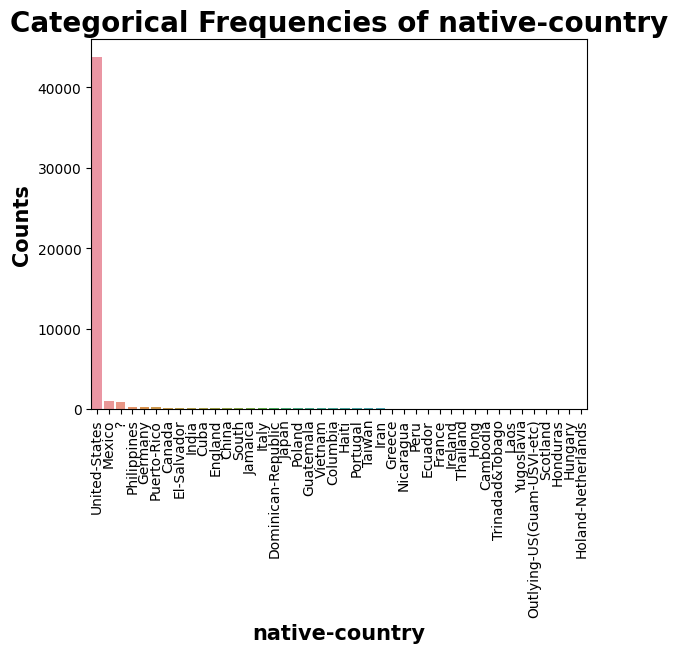

In [27]:
plot_bar(df2, cat_cols[7]);

> It appears that most of the individuals are from the states as the native country. *Like that number's too large!*

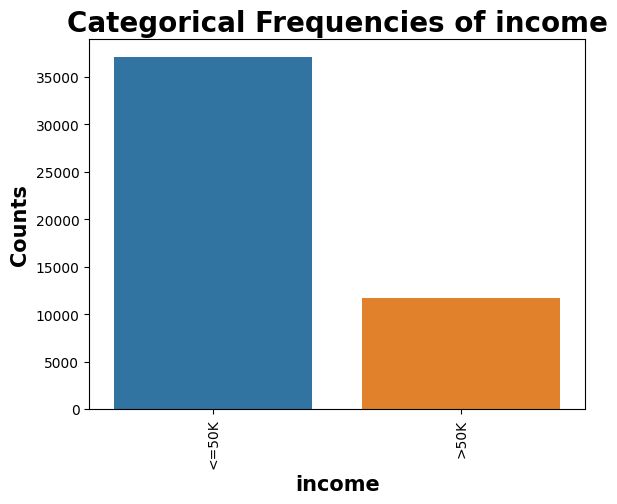

In [28]:
plot_bar(df2, cat_cols[8]);

> * The target feature doesn't seem to be balanced.
* There's a significant difference of over 2000 between the people who have incomes greater than 50k and the one's with less than or equal to 50k

### Visuals for EDA

In [29]:
# Final version of function
def feature_relations(df, x, y, figsize=(8,6), hue = 'income', fillna = True,
                      placeholder = 'MISSING'):

  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

  # Barplot
  sns.barplot(data=df, x=x, y=y, ax=ax, hue=hue)

  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")

  return fig, ax


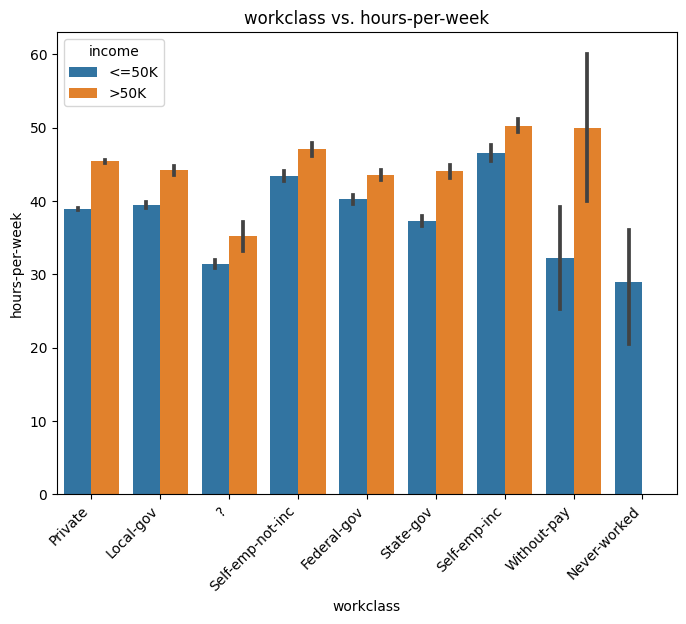

In [30]:
feature_relations(df2, 'workclass', 'hours-per-week');


> With the exception of the 'never-worked' category given the workclass and the hours-per-week features, we can see that those who earn more than 50k are greater in number than those who earn less than or equal to 50k

> It seems that no one earns greater than 50k in the category 'never-worked'. It might be due to the fact that they dedicate no time to the hours-per-week that should be worked.

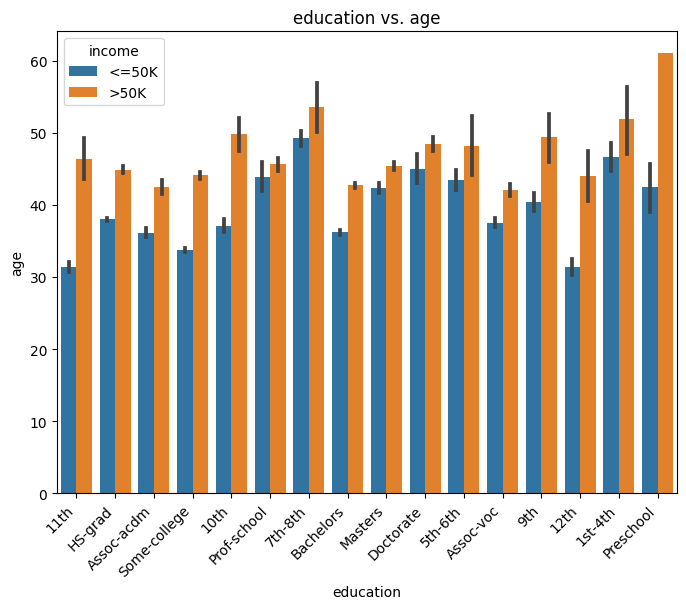

In [31]:
feature_relations(df2, 'education', 'age');


> It's visible that in all categories given both their age and education levels, the individuals who earn greater than 50k are more than those who earn less that or equal to 50k

### Final preprocessing

In [32]:
# replacing the feature values '?' with something more sensible.
repl_dict = { '?': 'unknown' }

df2['workclass'].replace(repl_dict, inplace=True)
df2['occupation'].replace(repl_dict, inplace=True)
df2['native-country'].replace(repl_dict, inplace=True)


#### numerical preprocessing pipeline formation

In [33]:
# getting numerical columns
num_cols = df2.select_dtypes("number").columns

# instantiate the scaler object
scaler = StandardScaler()

# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)

# numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


#### Ordinal preprocessing pipeline formation

In [34]:
# pointing out the ordinal columns
ord_cols = ['education']

# removing 'income' and 'education' from cat_cols variable
cat_cols = cat_cols[:-1]
cat_cols = cat_cols.drop(ord_cols)
print(cat_cols)

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object')


In [35]:
# Specifying order of categories for our  Ordinal Columms
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
                           '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-acdm',
                           'Assoc-voc', 'Bachelors', 'Masters', 'Doctorate', 'Prof-school']

# specifying a list of ordered categories
ordinal_category_orders = [education_order]
# instantiating the appropriate encoder
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

# Making a final scaler to scale categorys
scaler_ord = StandardScaler()
# Making an ord_pipe
ord_pipe = make_pipeline(ord_encoder, scaler_ord)

# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)


#### Categorical preprocessing pipeline formation

In [36]:
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)

# ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)


#### Column transformer formation

In [37]:
# Create the Column Transformer to combine all columns.
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)

X = df2.iloc[:, :-1]
y =  df2.iloc[:, -1]

# splitting dataframe into train and test portions
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


### Logistic Regression

In [38]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=500, random_state=42)

# Put scaler and model in a pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)
# commencing training endeavours.
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8...
                                                                   StandardScaler())]),
                                                  ['education']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     27841
        >50K       0.74      0.61      0.66      8751

    accuracy                           0.85     36592
   macro avg       0.81      0.77      0.79     36592
weighted avg       0.85      0.85      0.85     36592



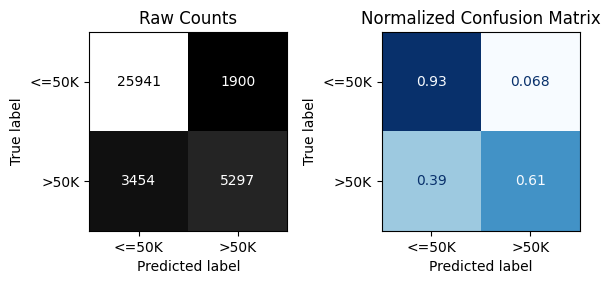


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      9268
        >50K       0.75      0.59      0.66      2930

    accuracy                           0.85     12198
   macro avg       0.81      0.76      0.78     12198
weighted avg       0.85      0.85      0.85     12198



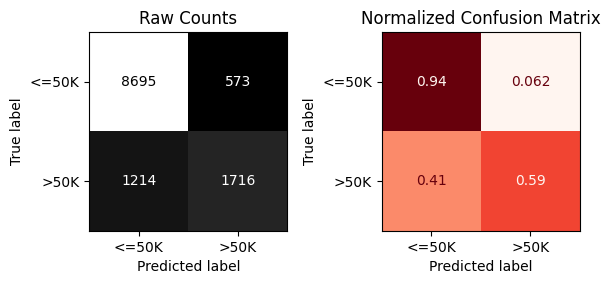

In [39]:
# Evaluate the default model
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)


In [40]:
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
             'logisticregression__penalty' : ['l1'],
             'logisticregression__C': [.01, .1, 1],
             'logisticregression__class_weight' : ["balanced", None]
             }

# Now make a list of the param dictionaries
param_grid = [l1_params]


In [41]:
# Create and fit the gridsearch and display results
gs = GridSearchCV(logreg_pipe, param_grid, verbose=True, n_jobs=-1, cv=3, return_train_score=True, scoring='recall_macro')

# grid search fitting on training data
gs.fit(X_train, y_train)
gs.best_params_
#

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'logisticregression__C': 0.1,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.87     27841
        >50K       0.57      0.85      0.68      8751

    accuracy                           0.81     36592
   macro avg       0.76      0.82      0.77     36592
weighted avg       0.85      0.81      0.82     36592



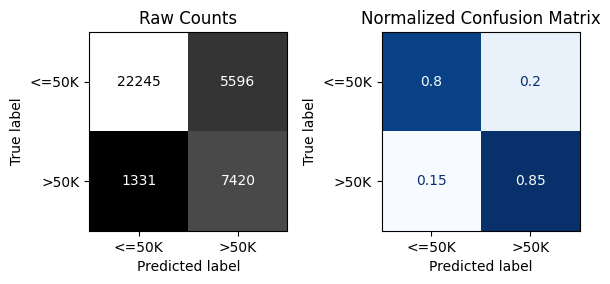


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.87      9268
        >50K       0.57      0.84      0.68      2930

    accuracy                           0.81     12198
   macro avg       0.76      0.82      0.77     12198
weighted avg       0.85      0.81      0.82     12198



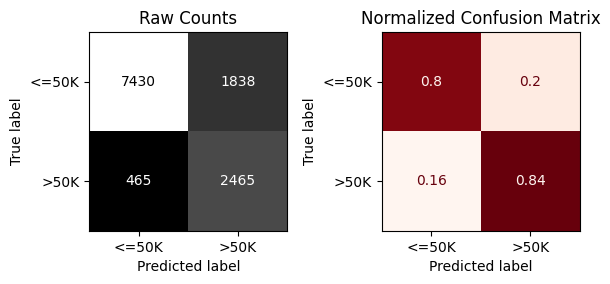

In [42]:
# Evalaute the best model
best_logreg = gs.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)

### K-Nearest Neighbours

In [43]:
# default KNN
knn = KNeighborsClassifier()

# KNN model pipeline
knn_pipe = make_pipeline(preprocessor, knn)
# Fit the model on the training data
knn_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['education']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.91      0.94      0.93     27841
        >50K       0.79      0.70      0.74      8751

    accuracy                           0.88     36592
   macro avg       0.85      0.82      0.83     36592
weighted avg       0.88      0.88      0.88     36592



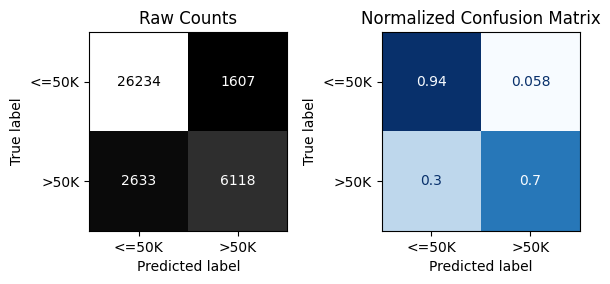


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89      9268
        >50K       0.68      0.59      0.64      2930

    accuracy                           0.84     12198
   macro avg       0.78      0.75      0.77     12198
weighted avg       0.83      0.84      0.83     12198



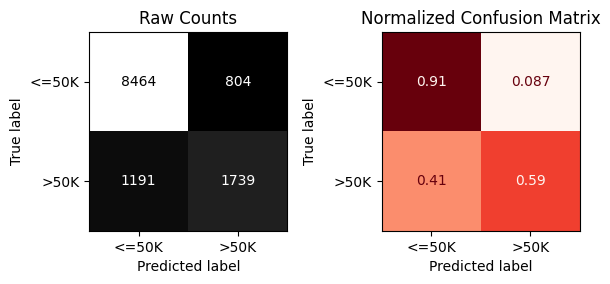

In [44]:
# Obtain evaluation metrics using custom function
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

In [45]:
# creating a neighbours list
nneighbors_list = list(range(10,15))

# Create param grid
params={ 'kneighborsclassifier__n_neighbors': nneighbors_list }


In [46]:
# Instaniate GridSearchCV
gs = GridSearchCV(knn_pipe, params, verbose=True, n_jobs=-1, cv=3, return_train_score=True, scoring='recall_macro')
# Fit gs on training data
gs.fit(X_train, y_train)
# Obtain best param value for K
gs.best_params_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'kneighborsclassifier__n_neighbors': 13}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     27841
        >50K       0.75      0.64      0.69      8751

    accuracy                           0.86     36592
   macro avg       0.82      0.79      0.80     36592
weighted avg       0.86      0.86      0.86     36592



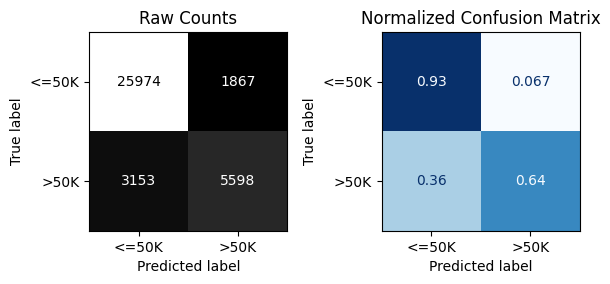


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      9268
        >50K       0.71      0.59      0.65      2930

    accuracy                           0.84     12198
   macro avg       0.79      0.76      0.77     12198
weighted avg       0.84      0.84      0.84     12198



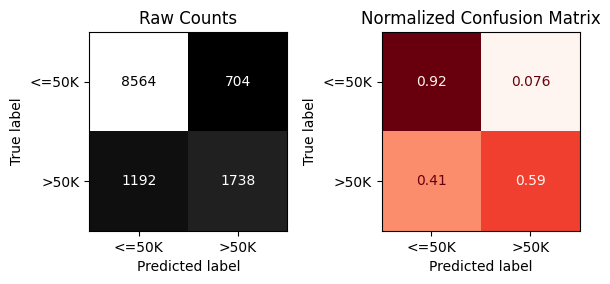

In [47]:
# evaluating the best knn model
evaluate_classification(gs.best_estimator_, X_train, y_train, X_test, y_test)


### Random Forest

In [48]:
# default random forest model
rf = RandomForestClassifier(random_state = 42)

# Model Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8...
                                                                   StandardScaler())]),
                                                  ['education']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     27841
        >50K       1.00      1.00      1.00      8751

    accuracy                           1.00     36592
   macro avg       1.00      1.00      1.00     36592
weighted avg       1.00      1.00      1.00     36592



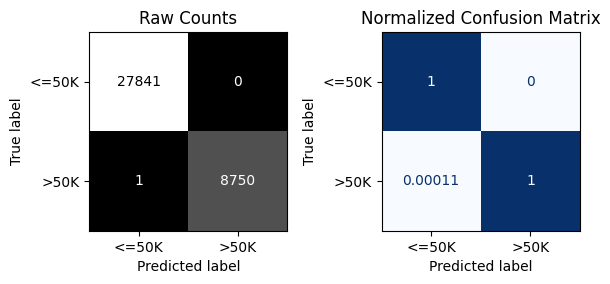


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      9268
        >50K       0.75      0.62      0.68      2930

    accuracy                           0.86     12198
   macro avg       0.82      0.78      0.79     12198
weighted avg       0.85      0.86      0.85     12198



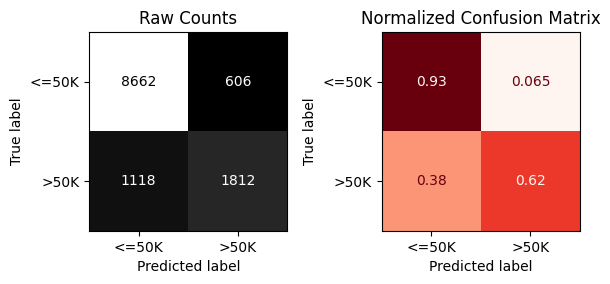

In [49]:
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

In [50]:
# parameter grid with tryable options ...
# most of the parameters tune out to the defaults.
params = {
          'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample'],
          'randomforestclassifier__oob_score': [True, False]
          }

In [51]:
# Instantiate the gridsearch
gs = GridSearchCV(rf_pipe, params, n_jobs=-1, cv=3, verbose=1, return_train_score=True, scoring='recall_macro')
# Fit the gridsearch on training data
gs.fit(X_train, y_train)
gs.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


{'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__oob_score': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     27841
        >50K       1.00      1.00      1.00      8751

    accuracy                           1.00     36592
   macro avg       1.00      1.00      1.00     36592
weighted avg       1.00      1.00      1.00     36592



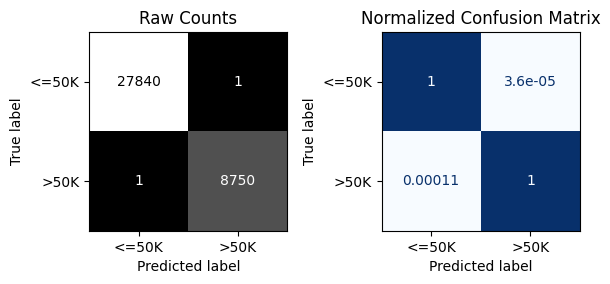


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      9268
        >50K       0.75      0.62      0.68      2930

    accuracy                           0.86     12198
   macro avg       0.82      0.78      0.79     12198
weighted avg       0.85      0.86      0.85     12198



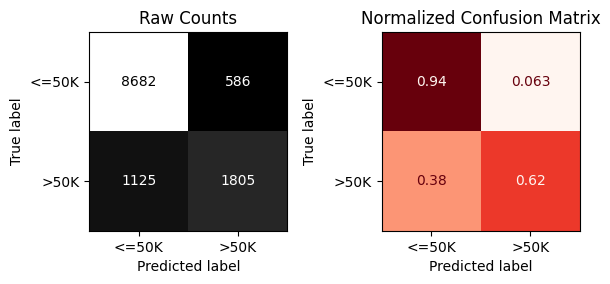

In [52]:
# Define and refit best model
best_rf = gs.best_estimator_
evaluate_classification(best_rf, X_train, y_train, X_test, y_test)


## checking for the defafult parameters

In [53]:
logreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
          'hours-per-week'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('ordinalencoder',
                                                     OrdinalEncoder(categories=[['Preschool',
                                                                                 '1st-4th',
                                                                                 '5th-6th',
                                                                                 '7th-8th',
                                                                                 '9th',
               

## Engaging PCA

In [54]:
# Instantiate PCA model
pca = PCA(n_components=.95)


### Within the logistics regression model

In [55]:
# Model Pipeline
logreg_pca_pipe = make_pipeline(preprocessor, pca, logreg)

#### Retrofitting tested finetuned parameter values
logreg_pca_pipe.set_params(**{
    'logisticregression__C': 0.1,
    'logisticregression__class_weight': 'balanced',
    'logisticregression__penalty': 'l1',
    'logisticregression__solver': 'liblinear'
    })

# Fit the model pipeline on the training data only
logreg_pca_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=500, penalty='l1', random_state=42,
                                    solver='liblinear'))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.79      0.86     27841
        >50K       0.56      0.84      0.67      8751

    accuracy                           0.81     36592
   macro avg       0.75      0.82      0.77     36592
weighted avg       0.85      0.81      0.82     36592



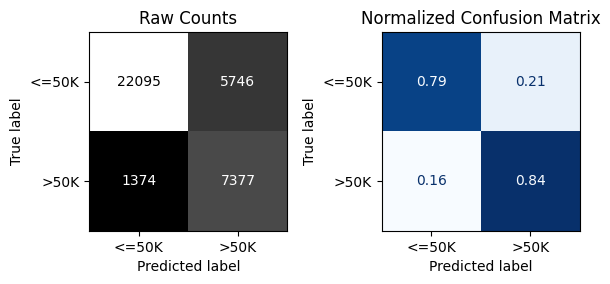


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      9268
        >50K       0.57      0.84      0.68      2930

    accuracy                           0.81     12198
   macro avg       0.75      0.82      0.77     12198
weighted avg       0.85      0.81      0.82     12198



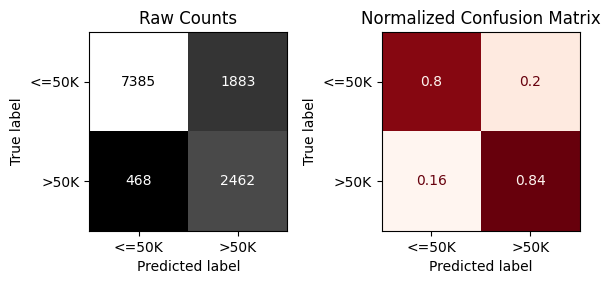

In [56]:
evaluate_classification(logreg_pca_pipe, X_train, y_train, X_test, y_test)

### Within the K-Nearest neighbours model

In [57]:
# Model Pipeline
knn_pca_pipe = make_pipeline(preprocessor, pca, knn)

#### Retrofitting tested finetuned parameter values
knn_pca_pipe.set_params(**{
    'kneighborsclassifier__n_neighbors': 13
    })

# Fit the model pipeline on the training data only
knn_pca_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8...
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=13))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     27841
        >50K       0.75      0.63      0.69      8751

    accuracy                           0.86     36592
   macro avg       0.82      0.78      0.80     36592
weighted avg       0.86      0.86      0.86     36592



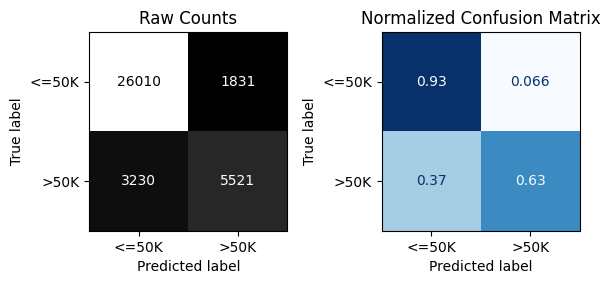


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      9268
        >50K       0.71      0.58      0.64      2930

    accuracy                           0.84     12198
   macro avg       0.79      0.75      0.77     12198
weighted avg       0.84      0.84      0.84     12198



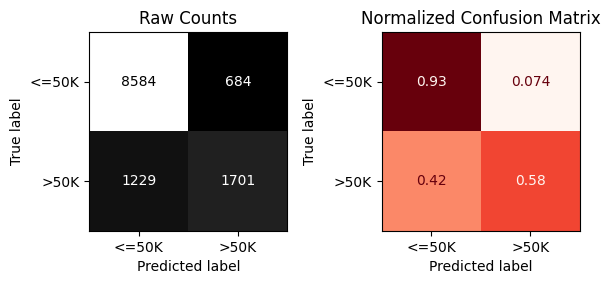

In [59]:
evaluate_classification(knn_pca_pipe, X_train, y_train, X_test, y_test)

### Within the Random Forest model

In [60]:
# Model Pipeline
rf_pca_pipe = make_pipeline(preprocessor, pca, rf)

#### Retrofitting tested finetuned parameter values
rf_pca_pipe.set_params(**{
    'randomforestclassifier__class_weight': 'balanced_subsample',
    'randomforestclassifier__oob_score': True
    })


# Fit the model pipeline on the training data only
rf_pca_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        oob_score=True, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     27841
        >50K       1.00      1.00      1.00      8751

    accuracy                           1.00     36592
   macro avg       1.00      1.00      1.00     36592
weighted avg       1.00      1.00      1.00     36592



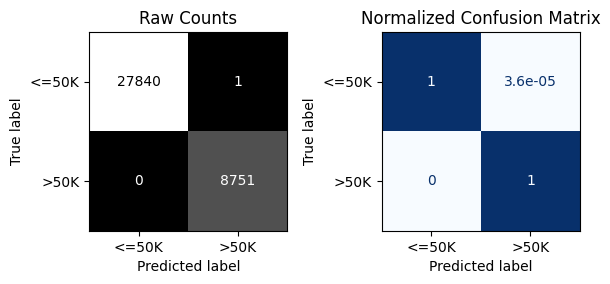


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      9268
        >50K       0.73      0.55      0.62      2930

    accuracy                           0.84     12198
   macro avg       0.80      0.74      0.76     12198
weighted avg       0.83      0.84      0.83     12198



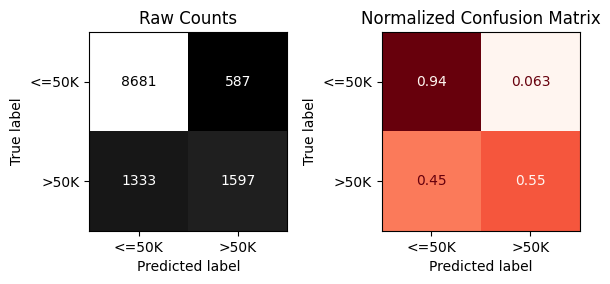

In [61]:
evaluate_classification(rf_pca_pipe, X_train, y_train, X_test, y_test)

## Choice of "production" model and decision justification.

I'd choose the logistic regression model with pca applied and customised finetunned parameters.

Misjudging incomes for individuals leads to overestimation of their expenditures and also accumulated loans that they prove hard to clear. Therefore using the recall of greaterthan 50% would provide the safest choice so that one can spend when they are sure that they can pay for it.



>Despite having less features to work with along with , it achieves the same percentage of recall at 84% compared to its finetunned model without pca, with a bonus of reduced execution time